# Predicting loan defaults


In this notebook I will use four common classification algorithms to predict whether a US citizen will default on their loan or not. Before building the models, I will clean the data, explore the dataset and then identify features which can be used in the models.

### Downloading and exploring the data set

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
import requests

This dataset is about past loans. It has been provided by IBM as part of their developer skills network product. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | The amount loaned                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


In [3]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv"
response = requests.get(url)

with open("loan_train.csv", "wb") as file:
    file.write(response.content)     #write the response content to the file 'loan_train'

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape #confirms that the dataset has been downloaded correctly

(346, 10)

Investigating the variables,


In [6]:
variables = ['loan_status', 'Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender']

for variable in variables:
    variable_class = df[variable].dtype
    print(f"The class of {variable} is {variable_class}") #show the class of each variable

The class of loan_status is object
The class of Principal is int64
The class of terms is int64
The class of effective_date is object
The class of due_date is object
The class of age is int64
The class of education is object
The class of Gender is object


It is better to convert a date to d datetime object so I will do that first

In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Exploring the data set further


In [8]:
df['loan_status'].value_counts() #show the number of rows for each of the two loan_status 

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [9]:
# install seaborn for data visualisation
#!conda install -c anaconda seaborn -y

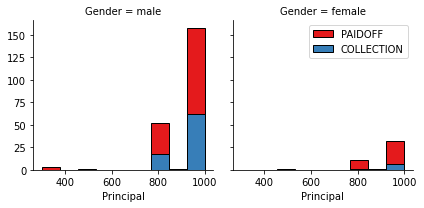

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10) #create bins for histogram
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2) #show number of males and females for each loan status
g.map(plt.hist, 'Principal', bins=bins, ec="k") #create histogram setting edge colour as black

g.axes[-1].legend()
plt.show()

Most of the loans have a value between 800 and 1000 USD. A higher number of loans are provided to males than females. Consequently there are more males who have gone into collection however it appears as if the proportion of people who have gone into collection versus who have paidoff is greater in males versus females.

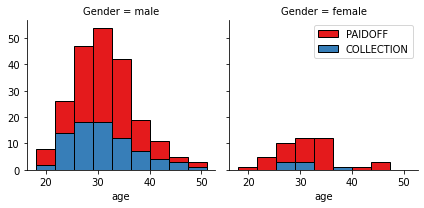

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")
#same code as above but creating histogram using age
g.axes[-1].legend()
plt.show()

The distribution of male's age is slightly right skewed. Most of the people who have gone into collection are in their late twenties / early thirties. 

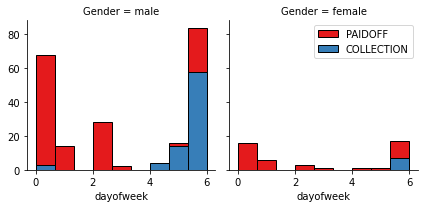

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek #get day of the week from the effective date
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()
#once again same code for histograms but using day of the week

It appears that people who get the loan at the end of the week don't pay it off, so I will use Feature binarization to set a threshold value less than day 4 and therefore classify the day as start of the week or weekend. Here the weekend is day 4,5,6 or 7.


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head() #simple check for correct feature binarization 

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Looking at factors

Firstly gender


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True) #nornalize=true to make it easier to see the split

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Converting male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


Now for loan_status. I will convert PAIDOFF to 0 and COLLECTION to 1

In [16]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


Now education,


In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

There appears to be a spelling mistake in the dataset for 'bechalor'. I believe this should read 'bachelor'. I am also confused as to what level of education this is. I will investigate this further if needed.

I will now use One Hot Encoding to create binary variables for 'Principal','terms','age','Gender' and 'education'

In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1) #create column for each level and give the row value 1 if the person takes this level of education
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### Feature Selection


Let's define feature sets, X:


In [20]:
X = Feature #explanatory variables / features
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


In [21]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [22]:
y #response variable

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [48]:
np.count_nonzero(y==1)

86

## Building a model

I will split the data into training set and a test set and then standardize the training set but not the test set to avoid data leakage and prevent the model having any knowledge of the test set. I will then use the following algorithms to predict whether a person will pay off their loan or not.

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

When the response variable is binary, logistic regression seems like the obvious algorithm to begin with. 

In [23]:
from sklearn.model_selection import train_test_split 
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) #set seed for reproducible results
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', x_test.shape, y_test.shape) #checking number of observations in training and test sets

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


In [24]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training set, the scaling parameters only calculated using training set
scaler.fit(X_train)

# Apply the scaler to both the training and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(x_test)

### Logistic Regression


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report 

LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_train_scaled, y_train) #C value is inverse of regularization. Regularization used to reduce overfitting, Higher c value decreases regularization and allows fit to be closer to data
LR

LogisticRegression(C=0.1, solver='liblinear')

Now to predict using test set

In [26]:
yhat = LR.predict(X_test_scaled)
yhat

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0], dtype=int64)

[[ 2 13]
 [ 6 49]]
Normalized confusion matrix
[[0.13333333 0.86666667]
 [0.10909091 0.89090909]]


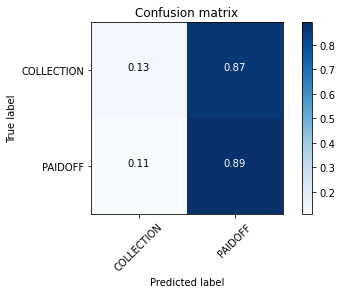

In [27]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print(confusion_matrix(y_test, yhat, labels=[1,0]))

cm = confusion_matrix(y_test, yhat, labels=[1, 0])
classes = ['COLLECTION', 'PAIDOFF']

plot_confusion_matrix(cm, classes, normalize=True)
plt.show()

The confusion matrix shows that when the true label was "PAIDOFF', the model predicted 'PAIDOFF' correctly 89% of the time. The model performs extremely poorly when the true label is 'COLLECTION', only correctly predicting 'COLLECTION' 13% of the time.  


In [29]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn import metrics 

#logistic regression model metrics
Logistic_Reg_log_loss = log_loss(y_test, yhat)
print("The log loss score for this model is: ", Logistic_Reg_log_loss)
Logistic_reg_jac_score = jaccard_score(y_test, yhat)
print("The jaccard score for this model is: ", Logistic_reg_jac_score)
Log_F1_score = metrics.f1_score(y_test, yhat, average='weighted')
print("The F1 score for this model is: ", Log_F1_score)
print(classification_report(y_test, yhat))

The log loss score for this model is:  9.783277348474655
The jaccard score for this model is:  0.09523809523809523
The F1 score for this model is:  0.6953867388649997
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        55
           1       0.25      0.13      0.17        15

    accuracy                           0.73        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.67      0.73      0.70        70



I am going to continue with other algorithms and come back to this model if necessary.

### K Nearest Neighbor(KNN)

In [30]:
from sklearn.neighbors import KNeighborsClassifier
k=4 #starting with k=4 as initial estimate
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
neigh
yhat_KNN = neigh.predict(X_test_scaled)
yhat_KNN[0:5]
from sklearn import metrics 
print("Training set accuracy:", metrics.accuracy_score(y_train, neigh.predict(X_train_scaled)))
print("Test set accuracy:", metrics.accuracy_score(y_test, yhat_KNN))

Training set accuracy: 0.7971014492753623
Test set accuracy: 0.7857142857142857


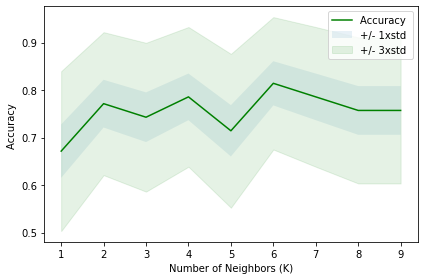

The best accuracy was with 0.8142857142857143 with k= 6


In [31]:
Ks = 10
mean_acc = np.zeros((Ks-1)) #create an array of size 9, initally all zeros
std_acc = np.zeros((Ks-1))

for n in range(1,Ks): #create loop to show mean accuracy for each value of k

   
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_scaled,y_train)
    yhat_KNN=neigh.predict(X_test_scaled)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_KNN) #adds the accuracy score to mean_acc array


    std_acc[n-1]=np.std(yhat_KNN==y_test)/np.sqrt(yhat_KNN.shape[0])

mean_acc
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

In [32]:
k=6
yhat_KNN_test = neigh.predict(X_test_scaled) 
#show metrics for k=6
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_KNN_test))
KNN_F1_score = metrics.f1_score(y_test, yhat_KNN_test, average='weighted')
print("The F1 score for this KNN model is:", KNN_F1_score)
KNN_jac_score = jaccard_score(y_test, yhat_KNN_test)
print("The jaccard score for this model is: ", KNN_jac_score)
print(classification_report(y_test, yhat_KNN_test))

Test set Accuracy:  0.7571428571428571
The F1 score for this KNN model is: 0.7381366459627329
The jaccard score for this model is:  0.19047619047619047
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        55
           1       0.40      0.27      0.32        15

    accuracy                           0.76        70
   macro avg       0.61      0.58      0.59        70
weighted avg       0.73      0.76      0.74        70



Jaccard score is low indicating that the predictions are not the true labels and the model is performing poorly. When looking at the classification report, it is clear that the model performs relatively well when predicting 'PAIDOFF' but poorly when predicting 'COLLECTION'. This is the same as the Logistic Regression model.

### Decision Tree


In [33]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion="entropy", max_depth=4) #criterion="entropy" is metric for impurity, at each node the tree aims to reduce imputirty and create pure subset
dtree.fit(X_train_scaled, y_train)
predTree = dtree.predict(X_test_scaled)

In [34]:
from matplotlib import pyplot as plt 
import matplotlib.pyplot as plt
print("Decision Tree's Accuracy:", metrics.accuracy_score(y_test, predTree))


Decision Tree's Accuracy: 0.7857142857142857


In [35]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

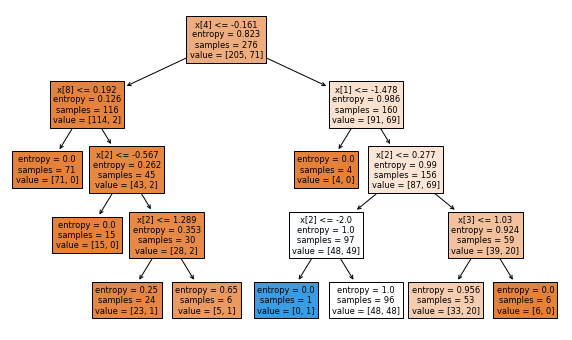

In [36]:
from sklearn import tree
# Plot the decision tree


plt.figure(figsize=(10, 6))
tree.plot_tree(dtree, filled=True)
plt.show()

In [37]:
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


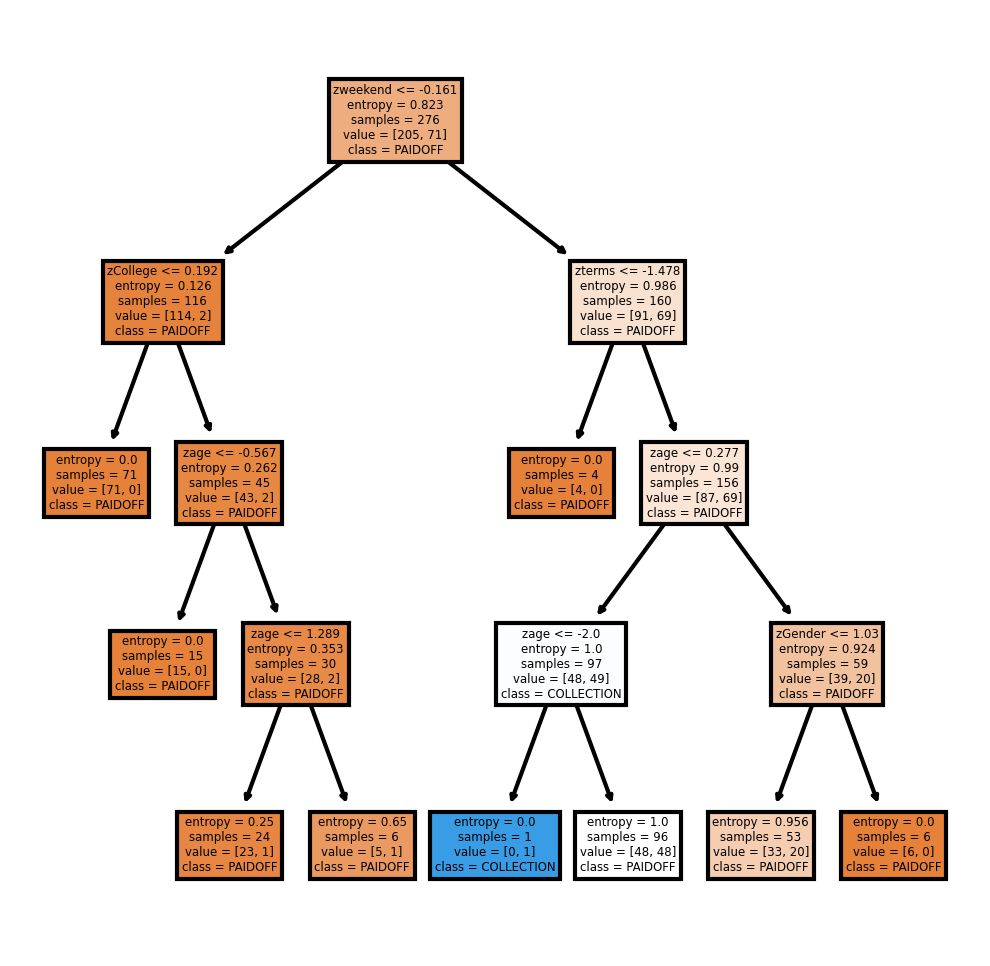

In [38]:
feature_name=['zPrincipal','zterms','zage','zGender','zweekend','zBechalor', 'zHS', 'zMas', 'zCollege'] #to show on decision tree plot
class_name=['PAIDOFF', 'COLLECTION']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dtree,
               feature_names = feature_name, 
               class_names=class_name,
               filled = True);

In [39]:
print("Decision Tree's Accuracy:", metrics.accuracy_score(y_test, predTree))

dtree_F1_score = metrics.f1_score(y_test, predTree, average='weighted') #average=weighted means the F1 score calculated for 'COLLECTION' and 'PAIDOFF' is weighted by number of instances in each class and then overall F1 score is average of these two values 
print("The F1 score for this Decision Tree model is:", dtree_F1_score)
dtree_jac_score = jaccard_score(y_test, predTree, average='weighted')
print("The jaccard score for this model is: ", dtree_jac_score)

Decision Tree's Accuracy: 0.7857142857142857
The F1 score for this Decision Tree model is: 0.6914285714285714
The jaccard score for this model is:  0.6173469387755102


The F1 score and jaccard score indicates that the model is not performing well. The information at each node also indicates this. For example there are only two nodes that are classified as 'COLLECTION' and they both only contain one more 'COLLECTION' data point than 'PAIDOFF'. 

# Support Vector Machine


SVM takes the feature data and uses a kernel function transform the data and then map it to a multi-dimensional space in order to find a separator between data points.

I will try SVM with the kernel functions; Linear, Polynomial, Radial Basis Function (RBF) and Sigmoid

In [40]:
from sklearn import svm 
model_rbf = svm.SVC(kernel='rbf') #kernel function is RBF
model_rbf.fit(X_train_scaled, y_train) #train the model on training data

SVC()

In [41]:
model_rbf_yhat=model_rbf.predict(X_test_scaled) #make predictions on test data

Using a confusion matrix again to assess predictions

[[ 4 11]
 [ 7 48]]
Normalized confusion matrix
[[0.26666667 0.73333333]
 [0.12727273 0.87272727]]


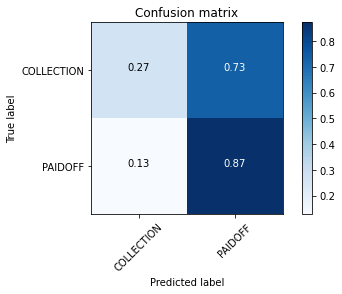

In [42]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print(confusion_matrix(y_test, model_rbf_yhat, labels=[1,0]))

cm = confusion_matrix(y_test, model_rbf_yhat, labels=[1, 0])
classes = ['COLLECTION', 'PAIDOFF']

plot_confusion_matrix(cm, classes, normalize=True)
plt.show()

In [43]:
model_linear = svm.SVC(kernel='linear') #kernel function is linear
model_linear.fit(X_train_scaled, y_train) #train the model on training data
model_linear_yhat=model_linear.predict(X_test_scaled) #make predictions on test data
print(confusion_matrix(y_test, model_linear_yhat, labels=[1,0]))

[[ 0 15]
 [ 0 55]]


In [44]:
model_sig = svm.SVC(kernel='sigmoid') #kernel function is sigmoid
model_sig.fit(X_train_scaled, y_train) #train the model on training data
model_sig_yhat=model_sig.predict(X_test_scaled) #make predictions on test data
print(confusion_matrix(y_test, model_sig_yhat, labels=[1,0]))

[[ 2 13]
 [ 5 50]]


In [45]:
model_poly = svm.SVC(kernel='poly') #kernel function is sigmoid
model_poly.fit(X_train_scaled, y_train) #train the model on training data
model_poly_yhat=model_poly.predict(X_test_scaled) #make predictions on test data
print(confusion_matrix(y_test, model_poly_yhat, labels=[1,0]))

[[ 1 14]
 [ 2 53]]


By only showing the basic print of the confusion matrices, it is clear that each model is not performing well when classifying data points that are 'COLLECTION'. Using the RBF kernel function gives a slight improvement but not enough to judge the model are functional. 

### Summary

All four algorithms are currently performing poorly and need further work. When comparing metrics, the decision tree algorithm has the greatest metrics accuracy score (0.786), a F1 score of 0.691 and Jaccard score of 0.617. The KNN model is closest in performance with a metrics accuracy score (0.757), an F1 score of 0.738 and a Jaccard score of 0.190. 

Each model performs extremely poorly when predicting 'COLLECTION'. I believe businesses would be most interested in predicting 'COLLECTION' so they can either decline the loan request or put measures in place to try and prevent the person from defaulting. 

The first step in improving the models will be to revisit the features included and perform feature engineering. Then I would focus on the decision tree algorithm first, possibly fine tuning the model by adjusting parameters.